In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

In [2]:
data

,date,open,high,low,close,volume
0,2004-01-02 00:00:00-05:00,1474.160034,1479.589966,1458.510010,1463.569946,1666780000
1,2004-01-05 00:00:00-05:00,1474.550049,1496.579956,1474.189941,1496.579956,2362910000
2,2004-01-06 00:00:00-05:00,1492.410034,1504.469971,1486.589966,1501.260010,2273220000
3,2004-01-07 00:00:00-05:00,1498.380005,1514.449951,1491.199951,1514.260010,2294280000
4,2004-01-08 00:00:00-05:00,1524.060059,1530.650024,1513.339966,1530.650024,2683950000
...,...,...,...,...,...,...
3519,2017-12-22 00:00:00-05:00,6462.549805,6467.830078,6449.000000,6465.169922,1541880000
3520,2017-12-26 00:00:00-05:00,6427.319824,6438.240234,6407.990234,6433.160156,1301000000
3521,2017-12-27 00:00:00-05:00,6437.060059,6448.939941,6425.919922,6435.149902,1411010000
3522,2017-12-28 00:00:00-05:00,6449.529785,6452.069824,6432.680176,6441.419922,1319870000


#### slice the data:

In [3]:
import numpy as np

# Create input sequences and targets
def create_sequences(features, target, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i+seq_length])  # Input sequence
        y_seq.append(target[i+seq_length]) # Target value (next data point)
    return np.array(X_seq), np.array(y_seq)

In [4]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

In [5]:
period = 60
output_step = 7

In [6]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

In [7]:
X.shape, y.shape

((3457, 60), (3457, 7))

In [8]:
X[0],y[0]

(array([1463.56994629, 1496.57995605, 1501.26000977, 1514.26000977,
        1530.65002441, 1520.45996094, 1539.77001953, 1524.7800293 ,
        1534.07995605, 1532.01000977, 1553.61999512, 1552.86999512,
        1546.59997559, 1530.42004395, 1531.20996094, 1553.66003418,
        1519.22998047, 1491.56994629, 1496.40002441, 1493.07995605,
        1487.83996582, 1491.84997559, 1462.60998535, 1465.0300293 ,
        1498.94995117, 1490.91003418, 1500.29003906, 1514.18005371,
        1501.33996582, 1484.4699707 , 1506.56994629, 1507.48999023,
        1484.80004883, 1482.09997559, 1463.75      , 1462.05004883,
        1470.2199707 , 1477.13000488, 1470.38000488, 1489.48999023,
        1473.2199707 , 1466.08996582, 1481.35998535, 1472.98999023,
        1441.11999512, 1437.4699707 , 1417.5       , 1402.19995117,
        1431.40002441, 1399.86999512, 1407.06994629, 1428.89001465,
        1417.77001953, 1398.57995605, 1381.39001465, 1370.04003906,
        1381.85998535, 1425.85998535, 1415.39001

In [9]:
data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [10]:
data_input, data_input.shape

(array([[1463.56994629, 1496.57995605, 1501.26000977, ..., 1508.36999512,
         1493.57995605, 1481.95996094],
        [1496.57995605, 1501.26000977, 1514.26000977, ..., 1493.57995605,
         1481.95996094, 1485.51000977],
        [1501.26000977, 1514.26000977, 1530.65002441, ..., 1481.95996094,
         1485.51000977, 1495.93005371],
        ...,
        [5934.91015625, 5932.31982422, 5867.35009766, ..., 6472.68994141,
         6465.16992188, 6433.16015625],
        [5932.31982422, 5867.35009766, 5881.33984375, ..., 6465.16992188,
         6433.16015625, 6435.14990234],
        [5867.35009766, 5881.33984375, 5937.79003906, ..., 6433.16015625,
         6435.14990234, 6441.41992188]]),
 (3457, 67))

#### seasonal_decomposition for each slice:

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions = np.array([seasonal_decompose(data_input[i], model='additive', period=14) for i in range(data_input.shape[0])])
trends = np.array([decompositions[i].trend for i in range(decompositions.shape[0])])

In [12]:
trends

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [13]:
trends[0]

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan, 1526.76785278,
       1531.22214181, 1533.9025007 , 1533.73392596, 1531.70035226,
       1529.49928066, 1526.66677856, 1523.63606044, 1519.90748814,
       1514.96284703, 1510.6182033 , 1506.45284598, 1502.58606393,
       1500.35213797, 1498.70535278, 1495.16749355, 1492.24427577,
       1492.36070469, 1492.51499285, 1491.70856585, 1490.45606777,
       1488.53142875, 1487.73893084, 1488.44285801, 1487.85464478,
       1486.7835737 , 1485.76606968, 1483.08177839, 1480.65070452,
       1479.52713449, 1476.77963693, 1471.94142369, 1467.03713553,
       1461.77999006, 1457.77106149, 1454.39498901, 1449.91891479,
       1445.94069999, 1442.33891514, 1437.21320016, 1430.68677194,
       1423.97677612, 1416.99285017, 1411.75606428, 1409.15392194,
       1408.40785435, 1409.57178606, 1411.85607474, 1413.92857579,
       1417.93750436, 1424.78500802, 1430.71322196, 1435.31607

In [14]:
trends.shape

(3457, 67)

In [15]:
trends_dropna = list()

for trend in trends:
    trends_dropna.append(trend[~np.isnan(trend)])

trends_dropna = np.array(trends_dropna)

In [16]:
trends_dropna.shape

(3457, 53)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = list(MinMaxScaler() for i in range(trends_dropna.shape[0]))
trends_scaled = list()

for i in range(trends_dropna.shape[0]):
    trends_scaled.append(scaler[i].fit_transform(trends_dropna[i].reshape(-1,1)))

trends_scaled = np.array(trends_scaled)

In [18]:
trends.shape, trends_dropna.shape, trends_scaled.shape

((3457, 67), (3457, 53), (3457, 53, 1))

In [19]:
trends_scaled[0], trends_scaled[0].shape

(array([[0.94314779],
        [0.97864165],
        [1.        ],
        [0.99865672],
        [0.98245225],
        [0.96491308],
        [0.94234238],
        [0.91819221],
        [0.8884812 ],
        [0.84907999],
        [0.81445983],
        [0.78126832],
        [0.75045599],
        [0.73265503],
        [0.71953267],
        [0.69134136],
        [0.66804779],
        [0.66897555],
        [0.67020499],
        [0.66377901],
        [0.65379851],
        [0.63846209],
        [0.6321471 ],
        [0.63775632],
        [0.63306916],
        [0.62453437],
        [0.61642642],
        [0.59503673],
        [0.5756648 ],
        [0.56671167],
        [0.54481832],
        [0.50626518],
        [0.46718552],
        [0.42529412],
        [0.39334911],
        [0.36644698],
        [0.33077953],
        [0.29907926],
        [0.27037855],
        [0.22953446],
        [0.17752883],
        [0.12406045],
        [0.06840926],
        [0.0266801 ],
        [0.00594502],
        [0

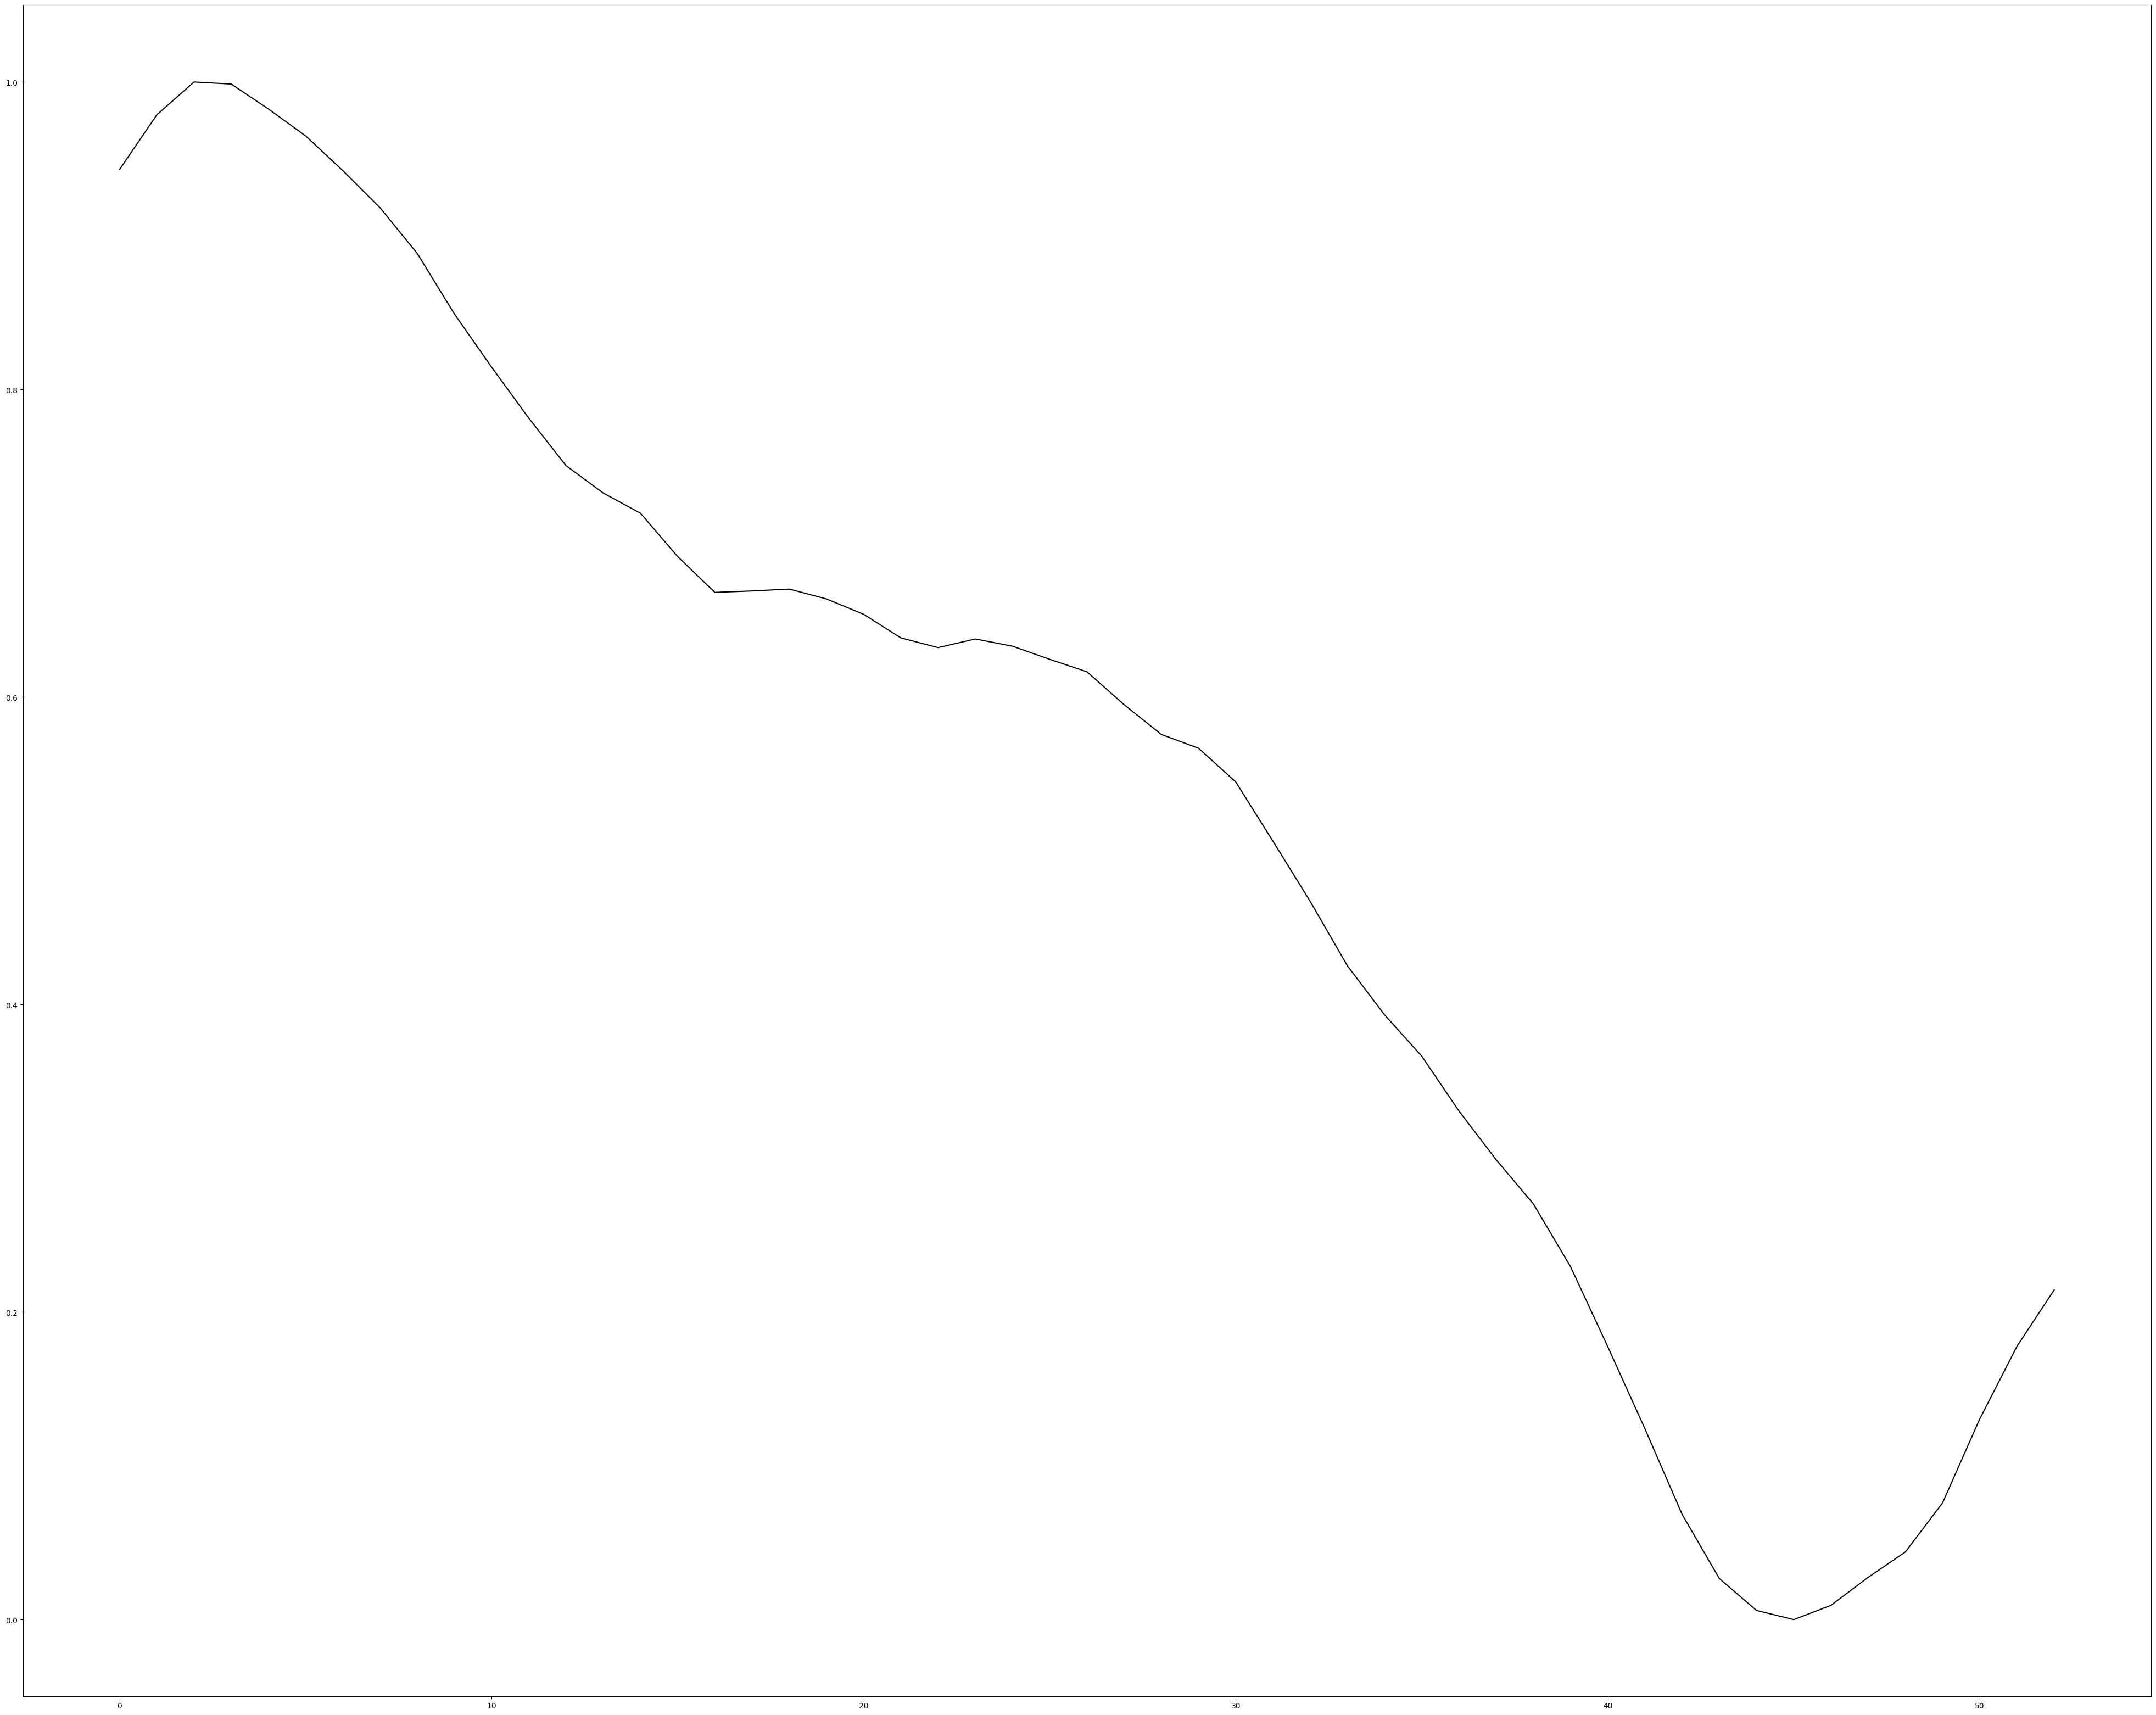

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trends_scaled[0], color='black')

In [21]:
X_input = list()
y_input = list()

for trend in trends_scaled:
    X_input.append(trend[:trend.shape[0]-7])
    y_input.append(trend[trend.shape[0]-7:])

X_input = np.array(X_input)
y_input = np.array(y_input)

In [22]:
X_input.shape, y_input.shape

((3457, 46, 1), (3457, 7, 1))

In [23]:
num_features = trends_scaled.shape[2]
input_period = X_input.shape[1]
output_step = y_input.shape[1]
units = 1024

In [24]:
y_input

array([[[0.00927475],
        [0.02747703],
        [0.04399169],
        ...,
        [0.13050082],
        [0.17773959],
        [0.21441728]],

       [[0.02747703],
        [0.04399169],
        [0.07593671],
        ...,
        [0.17773959],
        [0.21441728],
        [0.25742423]],

       [[0.04399169],
        [0.07593671],
        [0.13050082],
        ...,
        [0.21441728],
        [0.25742423],
        [0.31476023]],

       ...,

       [[0.86323914],
        [0.87587603],
        [0.89762635],
        ...,
        [0.94095546],
        [0.96908778],
        [1.        ]],

       [[0.85025784],
        [0.87196069],
        [0.89501663],
        ...,
        [0.9432662 ],
        [0.97411096],
        [1.        ]],

       [[0.84844495],
        [0.87168622],
        [0.89202705],
        ...,
        [0.95141633],
        [0.97751347],
        [1.        ]]])

## model training:

In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build LSTM model
model = Sequential([
    Bidirectional(LSTM(units, return_sequences=True), input_shape=(input_period, num_features)),
    LSTM(units=units, return_sequences=False),
    Dense(output_step)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define a ModelCheckpoint callback to save weights at the end of each epoch
checkpoint = ModelCheckpoint(filepath='model_weights_2_birnn/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)

# Adding early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-05-09 07:38:37.301492: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-05-09 07:38:37.337466: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-05-09 07:38:37.356366: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-05-09 07:38:37.382127: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-05-09 07:38:38.791422: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.


In [ ]:
# SKIP IF MODEL IS LOADED FROM .h5 FILE

# Training the model with early stopping
history = model.fit(X_input, y_input, epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/150
15/44 [=========>....................] - ETA: 6:18 - loss: 0.3679

In [30]:
# Select the epoch
best_epoch = np.argmin(history.history['val_loss'])
best_epoch = best_epoch+1
print(f'best result is for epoch number {best_epoch}')

# Load the weights of the model at the chosen epoch
model.load_weights(f'model_weights_2/model_weights_epoch_{best_epoch:02d}.h5')
print('Weigths for the best epoch has been loaded.')

best result is for epoch number 94
Weigths for the best epoch has been loaded.


In [27]:
best_epoch_backup = 94

# Load the weights of the model at the chosen epoch
model.load_weights(f'model_weights_2/model_weights_epoch_{best_epoch_backup:02d}.h5')
print('Backup: Weigths for the best epoch has been loaded.')

Backup: Weigths for the best epoch has been loaded.


## data testing:

In [28]:
data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [29]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [30]:
X_test.shape, y_test.shape

((4966, 60), (4966, 7))

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions_test = np.array([seasonal_decompose(X_test[i], model='additive', period=14) for i in range(X_test.shape[0])])
trends_test = np.array([decompositions_test[i].trend for i in range(decompositions_test.shape[0])])

In [32]:
trends_test[0], trends_test[0].shape

(array([          nan,           nan,           nan,           nan,
                  nan,           nan,           nan, 1526.76785278,
        1531.22214181, 1533.9025007 , 1533.73392596, 1531.70035226,
        1529.49928066, 1526.66677856, 1523.63606044, 1519.90748814,
        1514.96284703, 1510.6182033 , 1506.45284598, 1502.58606393,
        1500.35213797, 1498.70535278, 1495.16749355, 1492.24427577,
        1492.36070469, 1492.51499285, 1491.70856585, 1490.45606777,
        1488.53142875, 1487.73893084, 1488.44285801, 1487.85464478,
        1486.7835737 , 1485.76606968, 1483.08177839, 1480.65070452,
        1479.52713449, 1476.77963693, 1471.94142369, 1467.03713553,
        1461.77999006, 1457.77106149, 1454.39498901, 1449.91891479,
        1445.94069999, 1442.33891514, 1437.21320016, 1430.68677194,
        1423.97677612, 1416.99285017, 1411.75606428, 1409.15392194,
        1408.40785435,           nan,           nan,           nan,
                  nan,           nan,           

In [33]:
trends_test_dropna = list()

for trend in trends_test:
    trends_test_dropna.append(trend[~np.isnan(trend)])

trends_test_dropna = np.array(trends_test_dropna)

In [34]:
trends_test_dropna[0].shape

(46,)

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler_trend = list(MinMaxScaler() for i in range(trends_test_dropna.shape[0]))
trends_test_scaled = list()

scaler_target = list(MinMaxScaler() for i in range(y_test.shape[0]))
target_test_scaled = list()

for i in range(trends_test_dropna.shape[0]):
    trends_test_scaled.append(scaler_trend[i].fit_transform(trends_test_dropna[i].reshape(-1,1)))

for j in range(y_test.shape[0]):
    target_test_scaled.append(scaler_target[j].fit_transform(y_test[j].reshape(-1,1)))

trends_test_scaled = np.array(trends_test_scaled)
target_test_scaled = np.array(target_test_scaled)

In [36]:
trends_test_scaled.shape, target_test_scaled.shape

((4966, 46, 1), (4966, 7, 1))

In [37]:
# Model evaluation on test set
test_loss = model.evaluate(trends_test_scaled, target_test_scaled)
print(f'Model evaluation on test set: {test_loss}')

156/156 [==============================] - 93s 588ms/step - loss: 0.3021
Model evaluation on test set: 0.3021422028541565


In [38]:
trend_predictions = list()

for j in range(trends_test_scaled.shape[0]):
    print(j+1)
    trend_predictions.append(
        scaler_trend[j].inverse_transform(
            model.predict(trends_test_scaled[j].reshape(trends_test_scaled[j].shape[1], input_period, num_features), verbose=0)
        )
    )

trend_predictions = np.array(trend_predictions)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [39]:
trend_predictions.shape

(4966, 1, 7)

In [40]:
trend_predictions[0][0]

array([1409.8398, 1411.48  , 1414.244 , 1417.6675, 1421.658 , 1424.4816,
       1430.062 ], dtype=float32)

In [41]:
trends_test_dropna[0]

array([1526.76785278, 1531.22214181, 1533.9025007 , 1533.73392596,
       1531.70035226, 1529.49928066, 1526.66677856, 1523.63606044,
       1519.90748814, 1514.96284703, 1510.6182033 , 1506.45284598,
       1502.58606393, 1500.35213797, 1498.70535278, 1495.16749355,
       1492.24427577, 1492.36070469, 1492.51499285, 1491.70856585,
       1490.45606777, 1488.53142875, 1487.73893084, 1488.44285801,
       1487.85464478, 1486.7835737 , 1485.76606968, 1483.08177839,
       1480.65070452, 1479.52713449, 1476.77963693, 1471.94142369,
       1467.03713553, 1461.77999006, 1457.77106149, 1454.39498901,
       1449.91891479, 1445.94069999, 1442.33891514, 1437.21320016,
       1430.68677194, 1423.97677612, 1416.99285017, 1411.75606428,
       1409.15392194, 1408.40785435])

In [42]:
trend_predictions[0].shape, trends_test_dropna[0].shape

((1, 7), (46,))

In [43]:
decomposition_close_backup = seasonal_decompose(data_backup['close'], model='additive', period=period)
trend_close_backup = decomposition_close_backup.trend

trend_close_backup = trend_close_backup[~np.isnan(trend_close_backup)]

In [44]:
trend_close_backup

30       1477.012495
31       1476.375079
32       1475.489996
33       1474.889996
34       1474.504663
            ...     
4998    15463.493896
4999    15498.809326
5000    15534.079753
5001    15570.763761
5002    15607.284847
Name: trend, Length: 4973, dtype: float64

In [45]:
trends_dropna.shape

(3457, 53)

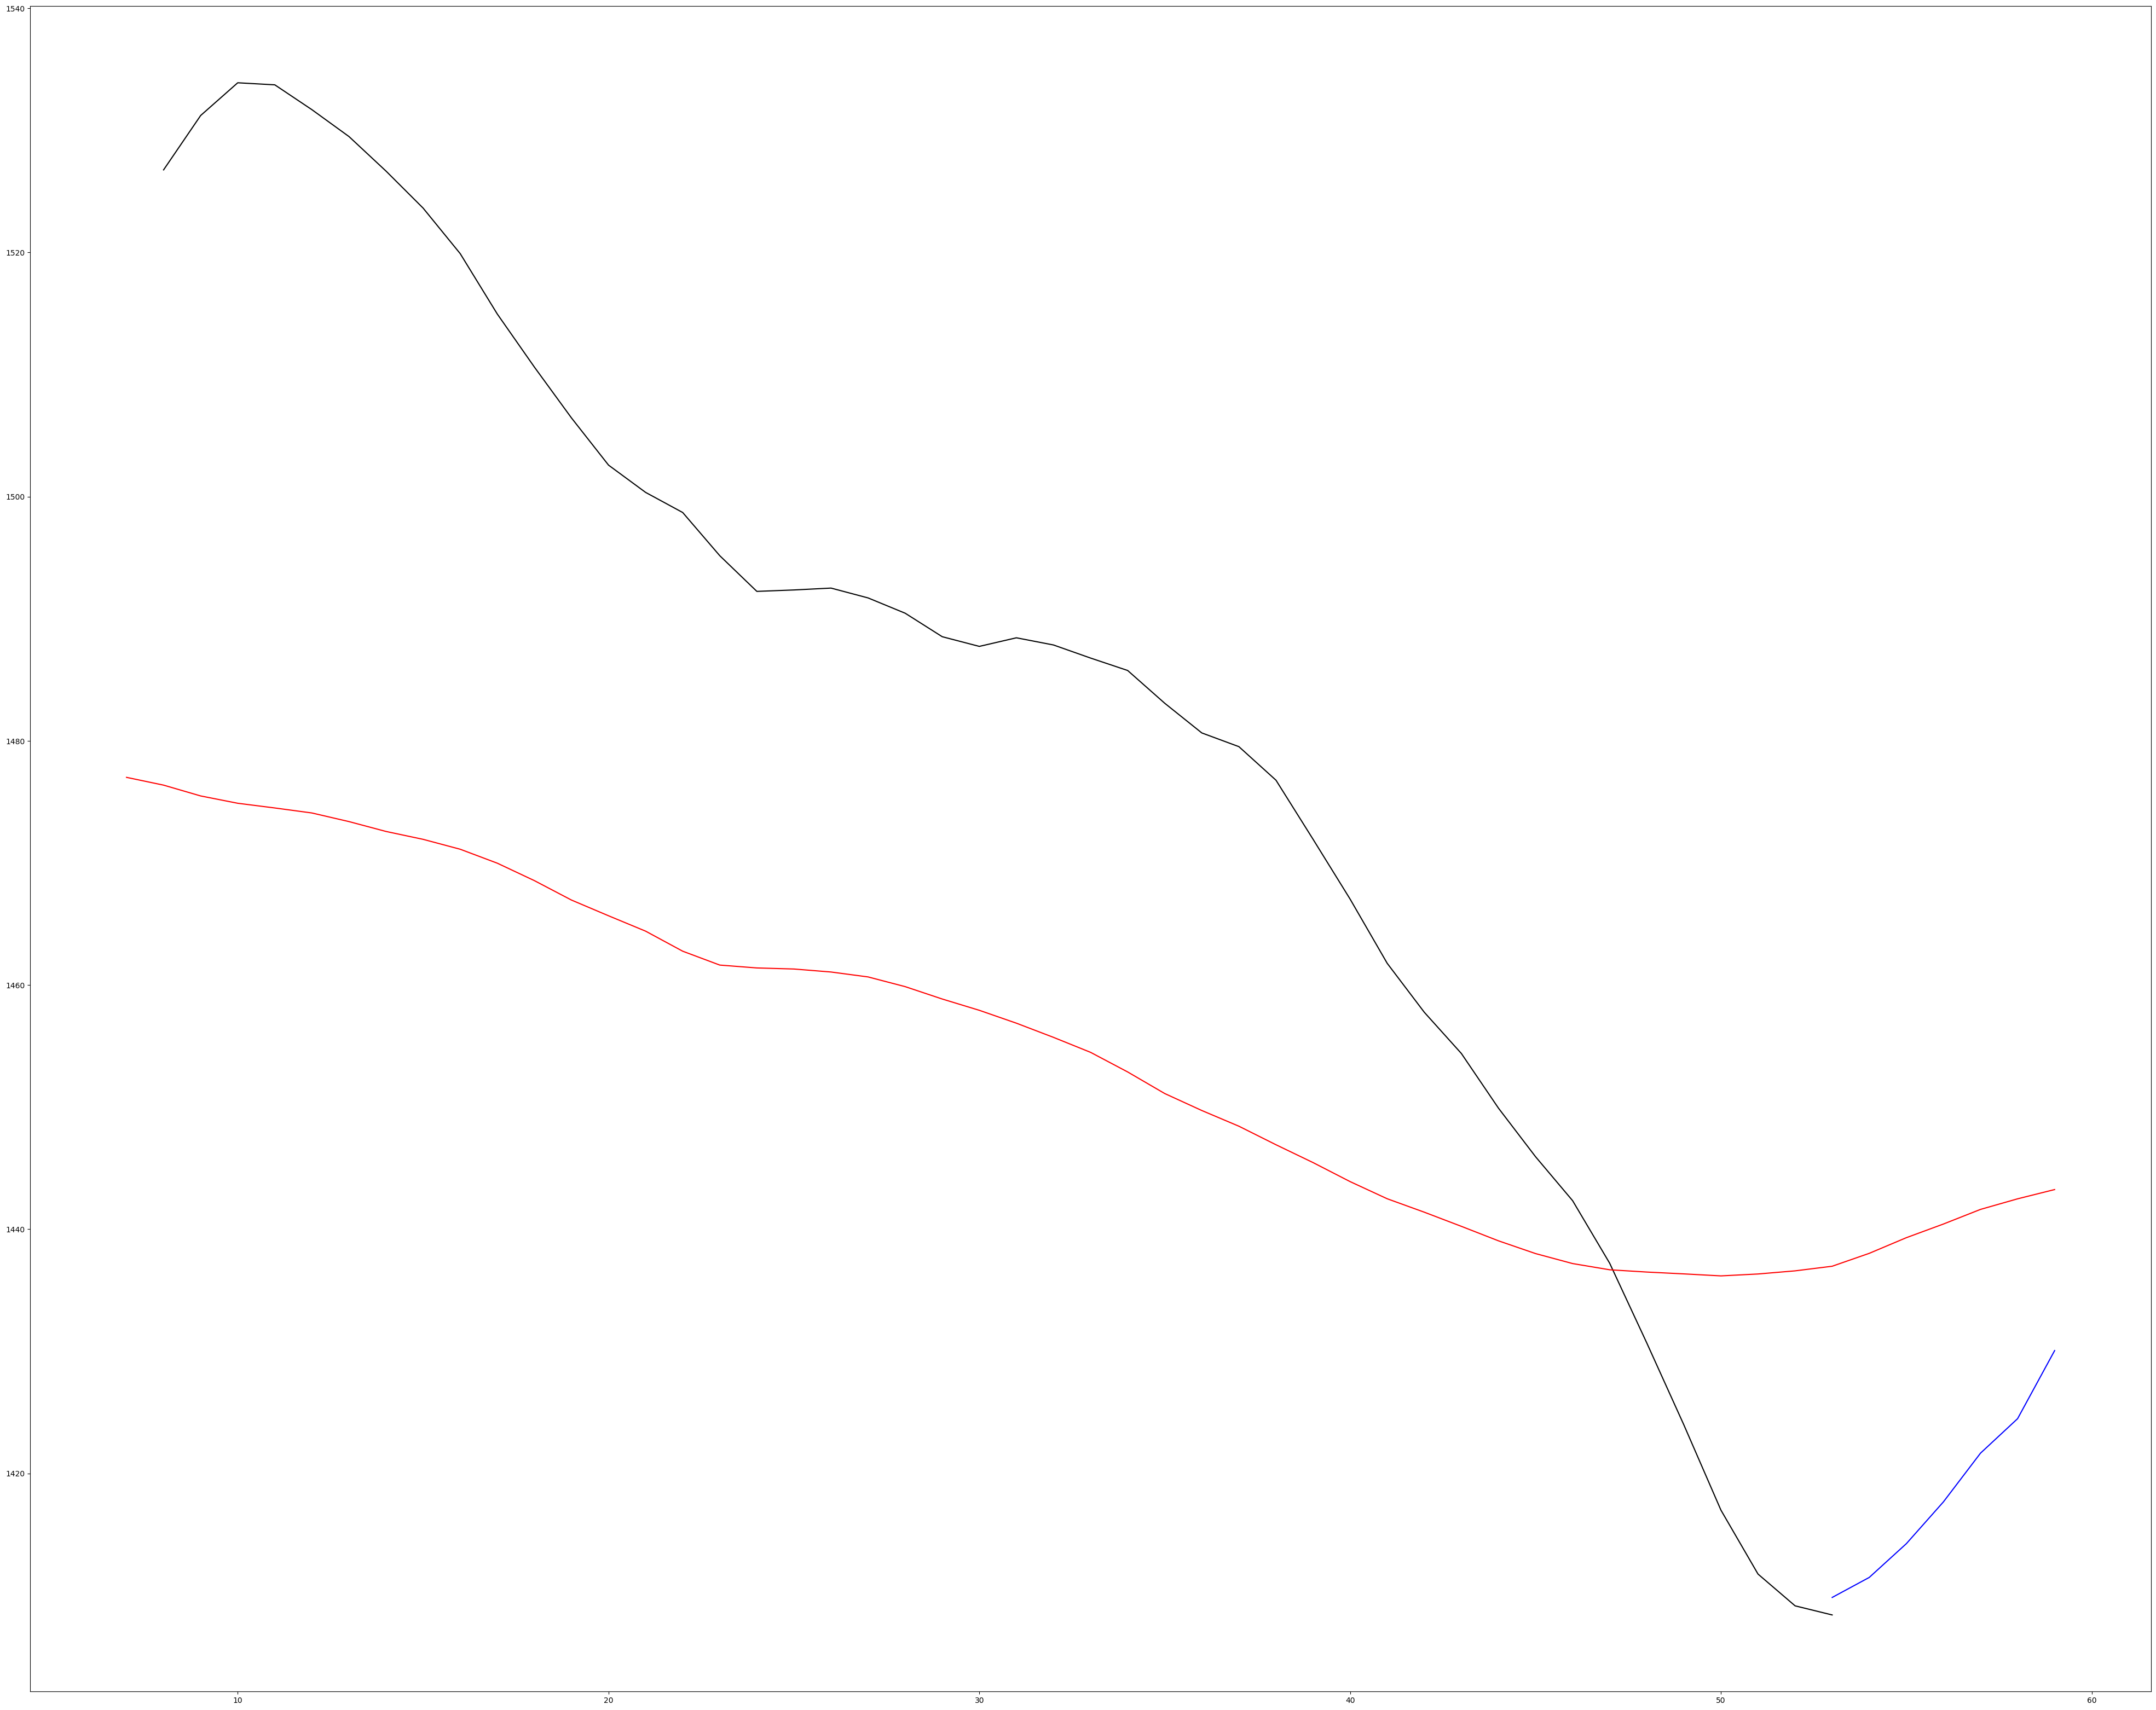

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(data_backup.index[53:60], trend_predictions[0][0], color='blue')
plt.plot(data_backup.index[8:54], trends_test_dropna[0], color='black')
plt.plot(data_backup.index[7:60], trend_close_backup[:53], color='red')

In [56]:
trends_test_dropna.shape

(4966, 46)

In [57]:
trends_test_df = pd.DataFrame(trends_test_dropna, index=data_backup.index[output_step:-period])

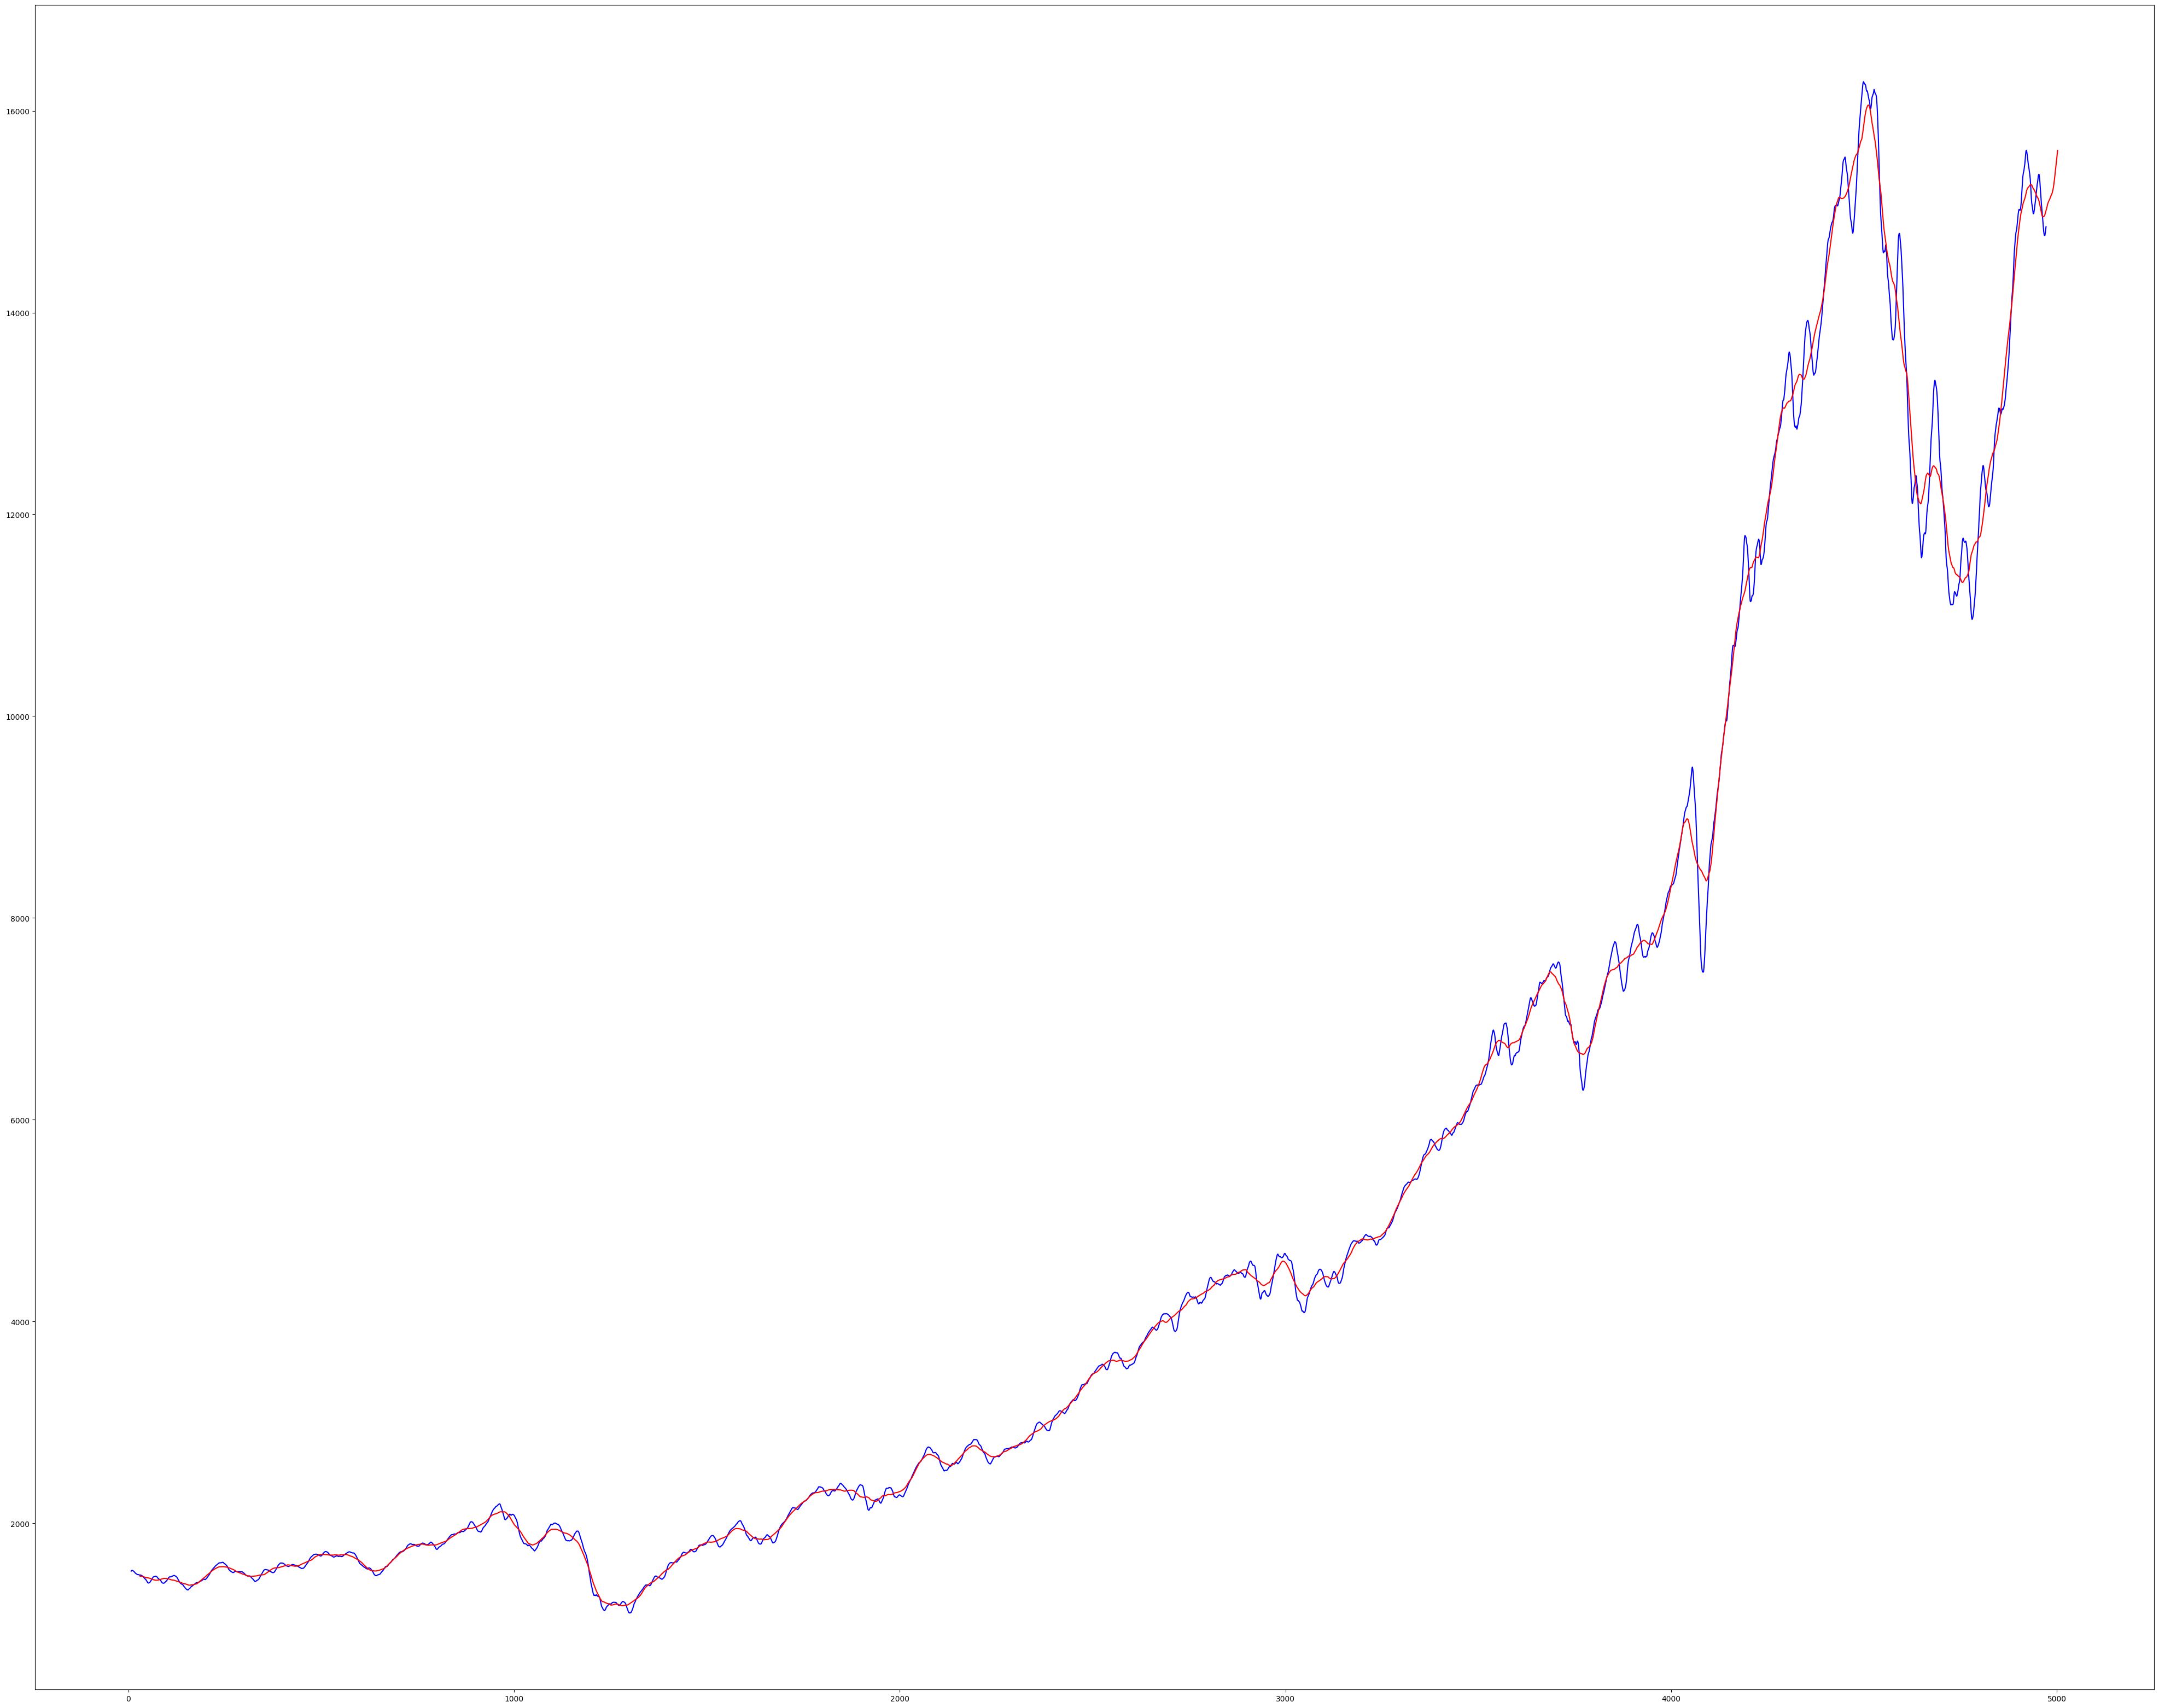

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trends_test_df[0], color='blue')
plt.plot(trend_close_backup, color='red')

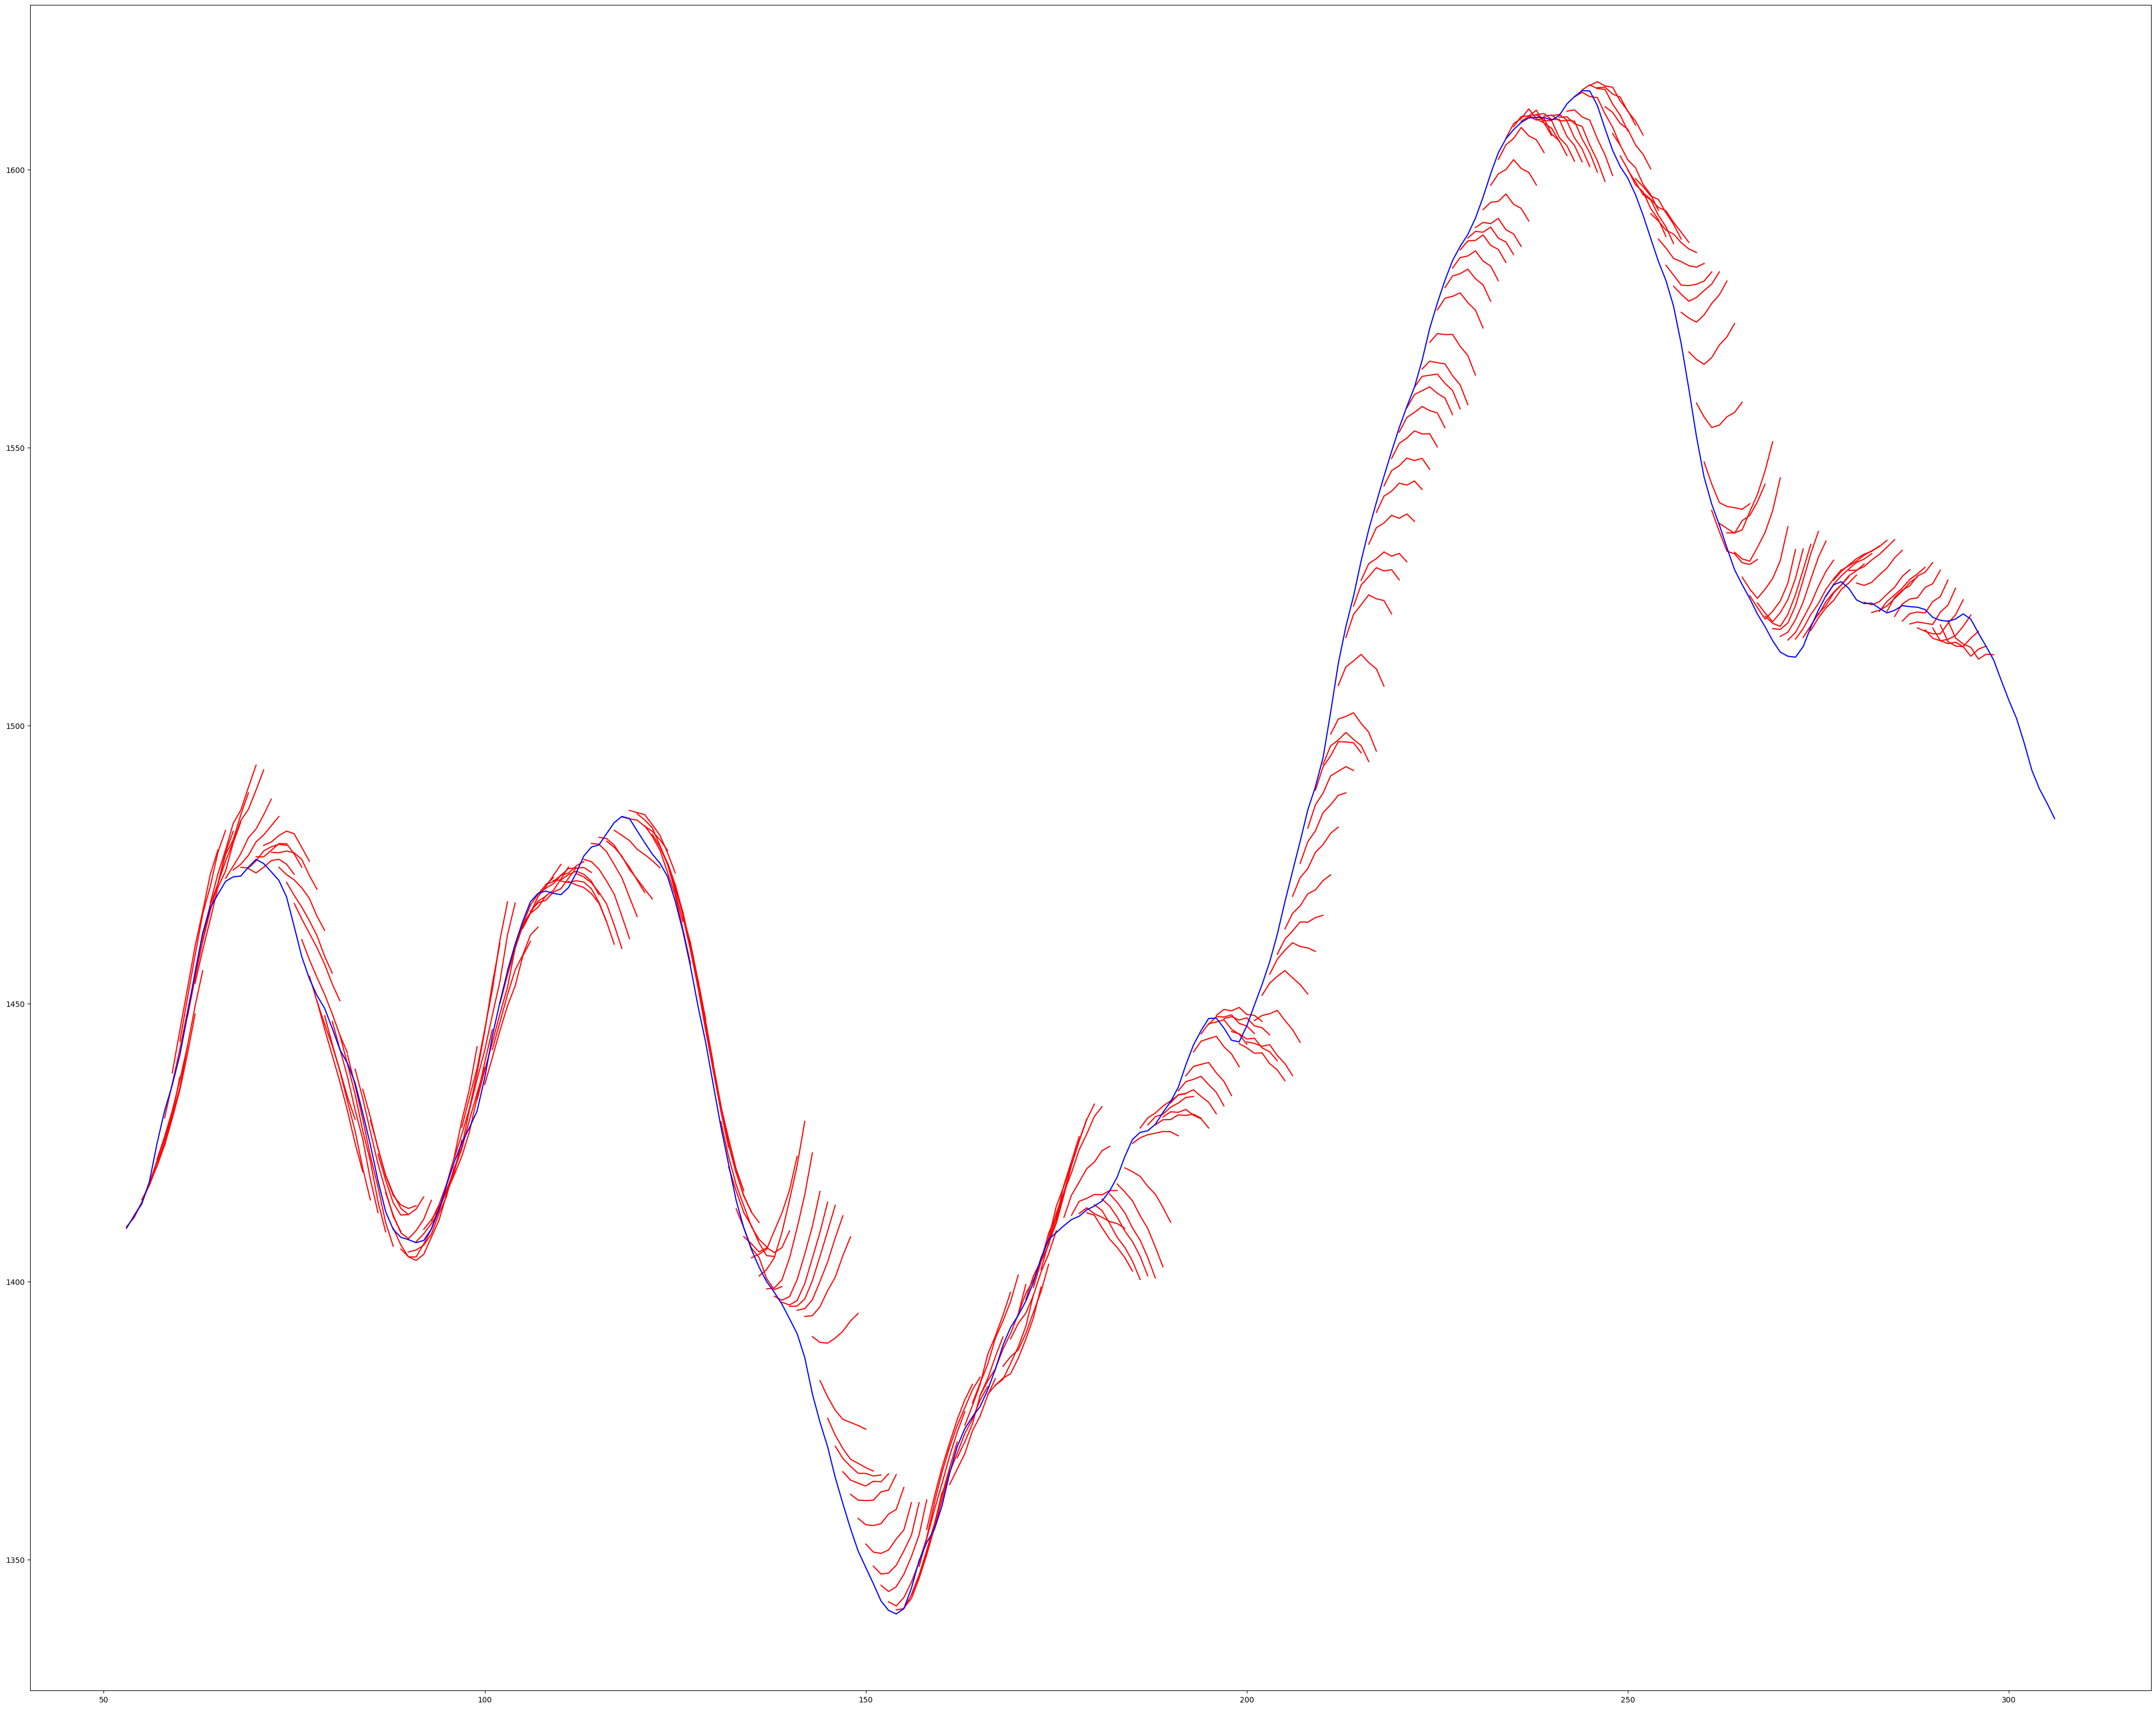

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

for i in range(240):
    plt.plot(data_backup.index[i+(input_period+output_step):i+period], trend_predictions[i][0], color='red')

plt.plot(trends_test_df[0].iloc[46:300], color='blue')

In [62]:
trend_predictions[1][0]

array([1411.8077, 1414.1357, 1417.5093, 1421.6005, 1425.8851, 1429.8624,
       1436.7649], dtype=float32)

In [63]:
trends_test_df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
7,1526.767853,1531.222142,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,...,1449.918915,1445.940700,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854
8,1531.222142,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,...,1445.940700,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786
9,1533.902501,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,...,1442.338915,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075
10,1533.733926,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,...,1437.213200,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576
11,1531.700352,1529.499281,1526.666779,1523.636060,1519.907488,1514.962847,1510.618203,1506.452846,1502.586064,1500.352138,...,1430.686772,1423.976776,1416.992850,1411.756064,1409.153922,1408.407854,1409.571786,1411.856075,1413.928576,1417.937504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,14762.375070,14763.000767,14788.303606,14825.085031,14850.414307,14880.882882,14922.623954,14949.350377,14959.149658,14951.692487,...,15790.537807,15841.763846,15885.636335,15915.112758,15930.188477,15931.478132,15937.199219,15952.771380,15968.534633,15990.509661
4969,14763.000767,14788.303606,14825.085031,14850.414307,14880.882882,14922.623954,14949.350377,14959.149658,14951.692487,14943.211740,...,15841.763846,15885.636335,15915.112758,15930.188477,15931.478132,15937.199219,15952.771380,15968.534633,15990.509661,16025.567139
4970,14788.303606,14825.085031,14850.414307,14880.882882,14922.623954,14949.350377,14959.149658,14951.692487,14943.211740,14943.527448,...,15885.636335,15915.112758,15930.188477,15931.478132,15937.199219,15952.771380,15968.534633,15990.509661,16025.567139,16065.452846
4971,14825.085031,14850.414307,14880.882882,14922.623954,14949.350377,14959.149658,14951.692487,14943.211740,14943.527448,14930.242815,...,15915.112758,15930.188477,15931.478132,15937.199219,15952.771380,15968.534633,15990.509661,16025.567139,16065.452846,16108.927455


In [66]:
observation_last_point = pd.Series([
    trend_predictions[i][0][-1] for i in range(trend_predictions.shape[0])
], index=trends_test_df.index)

observation_first_point = pd.Series([
    trend_predictions[i][0][0] for i in range(trend_predictions.shape[0])
], index=trends_test_df.index)

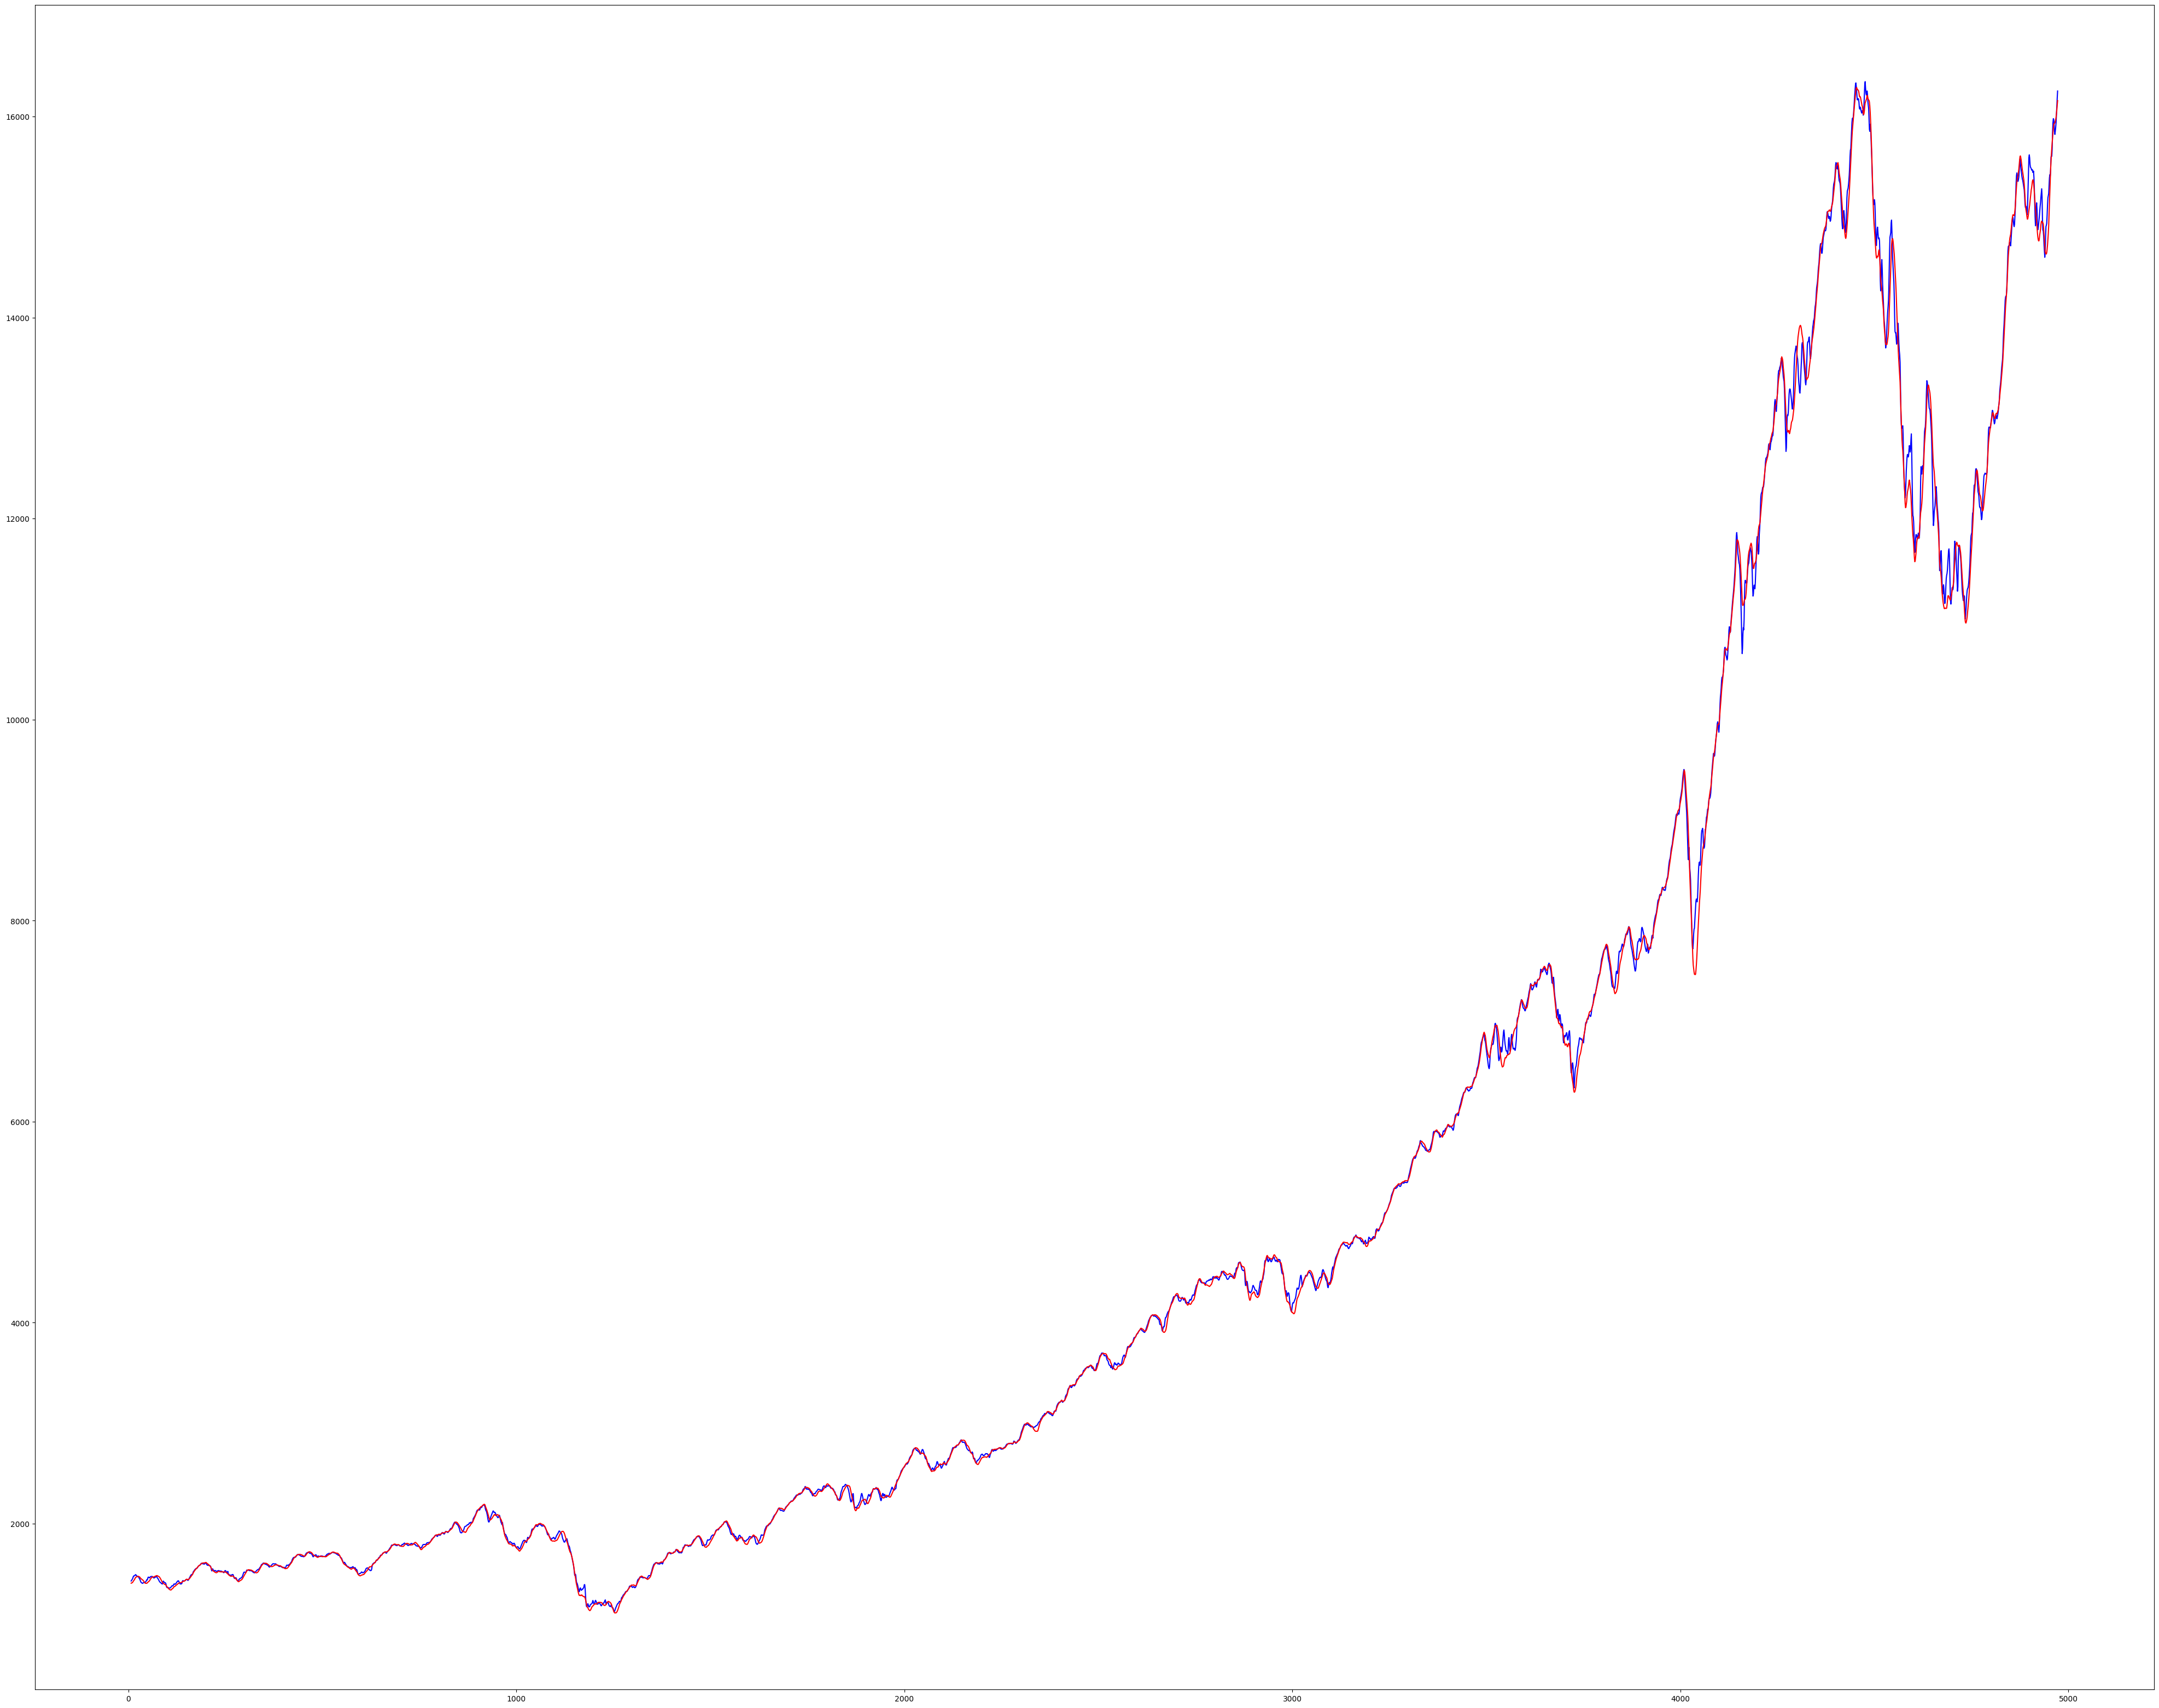

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(observation_last_point, color='blue')
plt.plot(trends_test_df[45], color='red')

## adding signal noise to trend predictions:

In [54]:
noise_high, _ = create_dataset(data_backup[['high']].to_numpy(), time_step=period, output_step=output_step)
noise_low, _ = create_dataset(data_backup[['low']].to_numpy(), time_step=period, output_step=output_step)

In [55]:
std_dev_high = np.array([np.std(val) for val in noise_high])
std_dev_low = np.array([np.std(val) for val in noise_low])

In [56]:
std_dev_noise = np.array([np.maximum(val_high, val_low) for val_high, val_low in zip(std_dev_high, std_dev_low)])

In [57]:
induced_high_first_point = np.array([observation_first_point[i+7] + std_dev_noise[i] for i in range(std_dev_noise.shape[0])])
induced_low_first_point = np.array([observation_first_point[i+7] - std_dev_noise[i] for i in range(std_dev_noise.shape[0])])

induced_high_last_point = np.array([observation_last_point[i+7] + std_dev_noise[i] for i in range(std_dev_noise.shape[0])])
induced_low_last_point = np.array([observation_last_point[i+7] - std_dev_noise[i] for i in range(std_dev_noise.shape[0])])

induced_high_first_point = pd.Series(induced_high_first_point, index=data_backup.index[7:-60])
induced_low_first_point = pd.Series(induced_low_first_point, index=data_backup.index[7:-60])
induced_high_last_point = pd.Series(induced_high_last_point, index=data_backup.index[7:-60])
induced_low_last_point = pd.Series(induced_low_last_point, index=data_backup.index[7:-60])

In [58]:
data_output = data_backup.copy()

In [59]:
data_output['observation_first_point'] = observation_first_point
data_output['induced_high_first_point'] = induced_high_first_point
data_output['induced_low_first_point'] = induced_low_first_point
data_output['observation_first_point'] = data_output['observation_first_point'].shift(46)
data_output['induced_high_first_point'] = data_output['induced_high_first_point'].shift(46)
data_output['induced_low_first_point'] = data_output['induced_low_first_point'].shift(46)

data_output['observation_last_point'] = observation_last_point
data_output['induced_high_last_point'] = induced_high_last_point
data_output['induced_low_last_point'] = induced_low_last_point
data_output['observation_last_point'] = data_output['observation_last_point'].shift(46)
data_output['induced_high_last_point'] = data_output['induced_high_last_point'].shift(46)
data_output['induced_low_last_point'] = data_output['induced_low_last_point'].shift(46)

In [61]:
data_output.to_excel(f'pred_trend_lstm_m5-correction-1024.xlsx')

### manual testing:

In [149]:
import pandas as pd

data_manual = pd.read_csv('data-nasdaq-2024/AAPL_raw_data.csv')
data_manual.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

In [150]:
data_manual

,date,open,high,low,close,volume
0,2023-08-08 00:00:00-04:00,179.690002,180.270004,177.580002,179.800003,67823000
1,2023-08-09 00:00:00-04:00,180.869995,180.929993,177.009995,178.190002,60378500
2,2023-08-10 00:00:00-04:00,179.479996,180.750000,177.600006,177.970001,54686900
3,2023-08-11 00:00:00-04:00,177.320007,178.619995,176.550003,177.789993,51988100
4,2023-08-14 00:00:00-04:00,177.970001,179.690002,177.309998,179.460007,43675600
...,...,...,...,...,...,...
160,2024-03-27 00:00:00-04:00,170.410004,173.600006,170.110001,173.309998,60273300
161,2024-03-28 00:00:00-04:00,171.750000,172.229996,170.509995,171.479996,65672700
162,2024-04-01 00:00:00-04:00,171.190002,171.250000,169.479996,170.029999,46240500
163,2024-04-02 00:00:00-04:00,169.080002,169.339996,168.229996,168.839996,49329500


In [151]:
data_manual = data_manual[151-53:151+7]

In [152]:
data_manual

,date,open,high,low,close,volume
98,2023-12-27 00:00:00-05:00,192.490005,193.500000,191.089996,193.149994,48087700
99,2023-12-28 00:00:00-05:00,194.139999,194.660004,193.169998,193.580002,34049900
100,2023-12-29 00:00:00-05:00,193.899994,194.399994,191.729996,192.529999,42628800
101,2024-01-02 00:00:00-05:00,187.149994,188.440002,183.889999,185.639999,82488700
102,2024-01-03 00:00:00-05:00,184.220001,185.880005,183.429993,184.250000,58414500
103,2024-01-04 00:00:00-05:00,182.149994,183.089996,180.880005,181.910004,71983600
104,2024-01-05 00:00:00-05:00,181.990005,182.759995,180.169998,181.179993,62303300
105,2024-01-08 00:00:00-05:00,182.089996,185.600006,181.500000,185.559998,59144500
106,2024-01-09 00:00:00-05:00,183.919998,185.149994,182.729996,185.139999,42841800
107,2024-01-10 00:00:00-05:00,184.350006,186.399994,183.919998,186.190002,46792900


In [153]:
data_manual.shape

(60, 6)

In [154]:
X_manual = np.array(data_manual['close'][:60].to_numpy())
#X_manual = np.array(data_manual['close'].to_numpy())

In [155]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_manual = seasonal_decompose(X_manual, model='additive', period=14)
trend_manual = decomposition_manual.trend

In [156]:
trend_manual = trend_manual[~np.isnan(trend_manual)]

In [157]:
from sklearn.preprocessing import MinMaxScaler

scaler_manual = MinMaxScaler()
data_manual_scaled = scaler_manual.fit_transform(trend_manual.reshape(-1,1))

In [158]:
pred_manual = model.predict(data_manual_scaled.reshape(data_manual_scaled.shape[1], input_period, 1))
pred_manual = scaler_manual.inverse_transform(pred_manual)

1/1 [==============================] - 0s 85ms/step


In [159]:
pred_manual

array([[172.92397, 173.09453, 173.40796, 173.62411, 173.89479, 174.0861 ,
        174.39584]], dtype=float32)